In [ ]:
! pip install extcolors

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from matplotlib import cm
from imageio import imread
from skimage.transform import resize
from matplotlib.colors import to_hex, to_rgba
from google.colab.patches import cv2_imshow
import cv2
import extcolors
import dlib

import copy

from os import listdir
from os.path import isfile, join

%matplotlib inline

In [ ]:
dir_path = r'/content/drive/MyDrive/csc_makeup/unzip_images/images/#v93oo'
file_name = '0a0f3092-ae26-42de-98fc-0c9cc1774221.jpg'
f = join(dir_path, file_name)

---

Download face landmarks predictor

In [ ]:
! wget https://github.com/justadudewhohacks/face-recognition.js-models/raw/master/models/mmod_human_face_detector.dat

--2021-04-08 04:13:09--  https://github.com/justadudewhohacks/face-recognition.js-models/raw/master/models/mmod_human_face_detector.dat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justadudewhohacks/face-recognition.js-models/master/models/mmod_human_face_detector.dat [following]
--2021-04-08 04:13:10--  https://raw.githubusercontent.com/justadudewhohacks/face-recognition.js-models/master/models/mmod_human_face_detector.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729940 (713K) [application/octet-stream]
Saving to: ‘mmod_human_face_detector.dat.2’

mmod_human_face_det 100%[============

In [ ]:
! wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

--2021-04-08 04:13:15--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2021-04-08 04:13:15--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat.2’

shape_predictor_68_ 100%[===================>

Makeup extractor

In [ ]:
class ExtractMakeup:
    def __init__(self, use_cnn_face_detector=False):
        # define landmarks numbers for different regions
        self.left_eyelid = [0] + list(range(17, 22)) + [27, 28]
        self.right_eyelid = [28, 27] + list(range(22, 27)) + [16]
        self.eyelids = [self.left_eyelid, self.right_eyelid]

        self.left_eye = list(range(36, 42))
        self.right_eye = list(range(42, 48))
        self.eyes = [self.left_eye, self.right_eye]

        self.mouth = list(range(48, 60))
        self.teeth = list(range(60, 68))

        self.use_cnn = use_cnn_face_detector
        if self.use_cnn:
            self.detector_weights_path = "/content/mmod_human_face_detector.dat"
            self.face_detector = dlib.cnn_face_detection_model_v1(self.detector_weights_path)
        else:
            self.face_detector = dlib.get_frontal_face_detector()
        self.predictor_weights_path = "/content/shape_predictor_68_face_landmarks.dat"
        self.landmarks_predictor = dlib.shape_predictor(self.predictor_weights_path)

        
    def get_landmarks(self, regions):
        points = []
        for region in regions:
            landmarks = self.landmarks_predictor(image=self.gray_img, box=self.face)
            cur_points = []

            for n in region:
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                cur_points.append(np.array([x, y]))
            
            points.append(np.array(cur_points))
        
        return points

    def extract(self, img):
        self.img = img
        self.mask = np.zeros(self.img.shape[:2], dtype=np.uint8)

        # face boundary box 
        self.gray_img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
        faces = self.face_detector(self.img)
        if not faces:
            return None
        if self.use_cnn:
            self.face = faces[0].rect
        else:
            self.face = faces[0]

        # eyelids + eyes region mask
        eyelids_landmarks = self.get_landmarks(self.eyelids)
        eyelids_mask = self.get_mask(eyelids_landmarks)

        # eyes region mask
        eyes_landmarks = self.get_landmarks(self.eyes)
        eyes_mask = self.get_mask(eyes_landmarks)

        # only eyelids mask
        eyelids_mask = cv2.bitwise_and(eyelids_mask, (255 - eyes_mask))

        # mouth region mask (lips + teeth)
        mouth_landmarks = self.get_landmarks([self.mouth])
        mouth_mask = self.get_mask(mouth_landmarks)
        
        # teeth region mask 
        teeth_landmarks = self.get_landmarks([self.teeth])
        teeth_mask = self.get_mask(teeth_landmarks)

        # lips (exclude teeth region)
        lips_mask = cv2.bitwise_and(mouth_mask, (255-teeth_mask))

        # full mask
        self.mask = cv2.bitwise_or(eyelids_mask, lips_mask)
        self.mask = np.array([self.mask]*3)
        self.mask = np.transpose(self.mask, [1, 2, 0])

        # get regions from input image
        self.img_mask = cv2.bitwise_and(self.img, self.mask)

        self.top = np.min([y for eye in eyelids_landmarks for x, y in eye])
        self.bottom = np.max([y for m in mouth_landmarks for x, y in m])
        self.left = np.min([x for eye in eyelids_landmarks for x, y in eye])
        self.right = np.max([x for eye in eyelids_landmarks for x, y in eye])

        self.img_crop = self.img_mask[self.top:self.bottom, self.left:self.right]
        self.mask_crop = self.mask[self.top:self.bottom, self.left:self.right]

        self.transparent_img = self.add_transparent_background(self.img_crop, self.mask_crop)
        return self.transparent_img

    def get_mask(self, points):
        mask = np.zeros(self.img.shape[:2], dtype=np.uint8)
        mask = cv2.fillPoly(mask, points, 255)
        return mask

    def add_transparent_background(self, img, mask):
        res = img.copy()
        res = cv2.cvtColor(res, cv2.COLOR_BGR2BGRA)
        res[:, :, 3] = mask[:, :, 0]
        return res

    def plot_face_box(self):
        x = self.face.left()
        y = self.face.top()
        w = self.face.right() - x
        h = self.face.bottom() - y
        img = self.img.copy()
        plt.imshow(cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 2))

Color palette extractor

In [ ]:
class ExtractColors:
    def __init__(self):
        pass
    
    def extract(self, img):
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img, 'RGBA')
        
        self.colors, pixel_count = extcolors.extract_from_image(img)

        return self.colors

---

Create color palette visualization

In [ ]:
def create_color_palette(palette, proportionately=False, height=300, width=50):
    total_pixels = sum([pixels_count for color, pixels_count in palette])

    bar = np.zeros((height, width, 3), dtype = "uint8")
    start_y = 0

    if not proportionately:
        percent = 1 / len(palette)
    
    for color, pixels_count in palette:
        if proportionately:
            percent = pixels_count / total_pixels
        end_y = start_y + (percent * height)
        top_left_corner = (0, int(start_y))
        bottom_right_corner = (width, int(end_y))
        cv2.rectangle(bar, top_left_corner, bottom_right_corner, 
                      np.array(color).astype("uint8").tolist(), -1)
        start_y = end_y
	
    return bar

Plot original image, extracted makeup and color palette

In [ ]:
def plot_results(img, makeup_extractor, colors_extractor):
    makeup = makeup_extractor.extract(img)
    colors = colors_extractor.extract(makeup)
    palette = create_color_palette(colors)

    f = plt.figure(figsize=(10, 5))

    plt.subplot(131, autoscale_on=True)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(132, autoscale_on=True)
    plt.imshow(makeup)
    plt.axis('off')

    plt.subplot(133, autoscaley_on=True)
    plt.imshow(palette)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.show()

In [ ]:
img = plt.imread(f)

In [ ]:
color_palette_extractor = ExtractColors()

with `dlib.cnn_face_detection_model_v1`


In [ ]:
makeup_extractor = ExtractMakeup(use_cnn_face_detector=True)

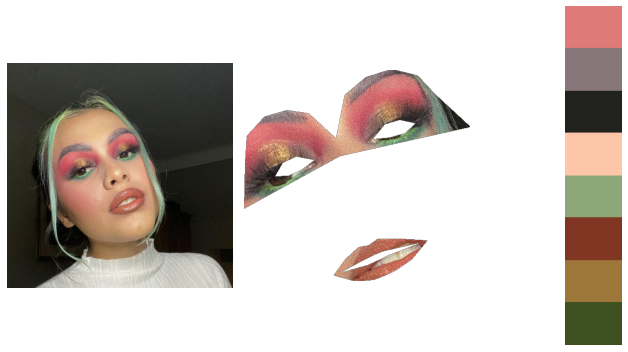

In [ ]:
plot_results(img, makeup_extractor, color_palette_extractor)

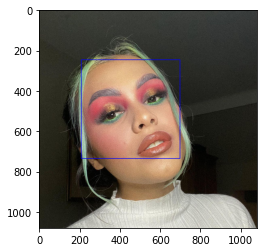

In [ ]:
makeup_extractor.plot_face_box()

with `dlib.get_frontal_face_detector`

In [ ]:
makeup_extractor = ExtractMakeup(use_cnn_face_detector=False)

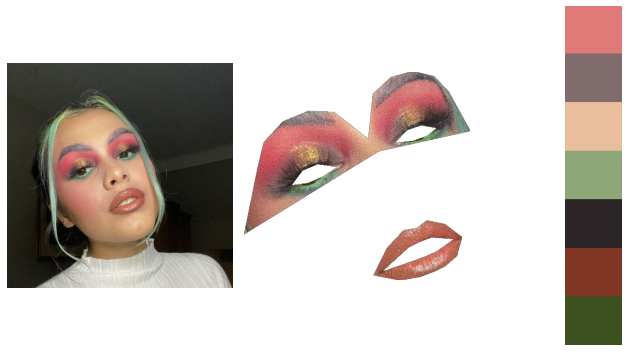

In [ ]:
plot_results(img, makeup_extractor, color_palette_extractor)

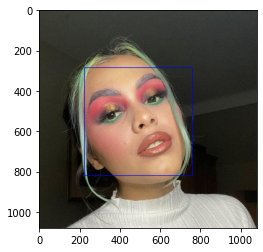

In [ ]:
makeup_extractor.plot_face_box()

with `dlib.cnn_face_detection_model_v1`

In [ ]:
img = plt.imread(r'/content/drive/MyDrive/csc_makeup/unzip_images/images/#v93oo/49d46f70-9bc5-4c8f-9cc8-415358cb0ea1.jpg', 'jpg')

In [ ]:
makeup_extractor = ExtractMakeup(use_cnn_face_detector=True)

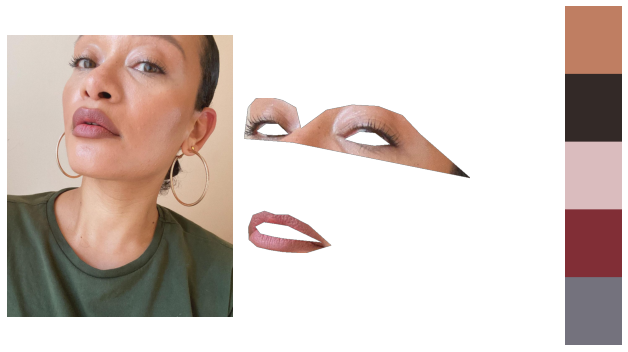

In [ ]:
plot_results(img, makeup_extractor, color_palette_extractor)

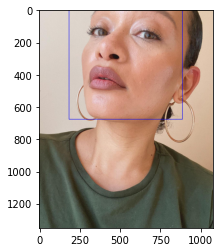

In [ ]:
makeup_extractor.plot_face_box()

with `dlib.get_frontal_face_detector`

In [ ]:
makeup_extractor = ExtractMakeup(use_cnn_face_detector=False)

In [ ]:
plot_results(img, makeup_extractor, color_palette_extractor) # detector doesn't find any face

AttributeError: ignored

---

In [ ]:
class ExtractMakeup:
    def __init__(self, separate_masks=False):
        self.separate_masks = separate_masks
        # define landmarks numbers for different regions
        self.left_eyelid = [0] + list(range(17, 22)) + [27, 28]
        self.right_eyelid = [28, 27] + list(range(22, 27)) + [16]
        self.eyelids = [self.left_eyelid, self.right_eyelid]

        self.left_eye = list(range(36, 42))
        self.right_eye = list(range(42, 48))
        self.eyes = [self.left_eye, self.right_eye]

        self.mouth = list(range(48, 60))
        self.teeth = list(range(60, 68))

        self.face_detector = dlib.get_frontal_face_detector()
        self.predictor_path = "/content/shape_predictor_68_face_landmarks.dat"
        self.landmarks_predictor = dlib.shape_predictor(self.predictor_path)

        
    def get_landmarks(self, regions):
        points = []
        for region in regions:
            landmarks = self.landmarks_predictor(image=self.gray_img, box=self.face)
            cur_points = []

            for n in region:
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                cur_points.append(np.array([x, y]))
            
            points.append(np.array(cur_points))
        
        return points

    def extract(self, img):
        self.img = img
        self.mask = np.zeros(self.img.shape[:2], dtype=np.uint8)

        # face boundary box 
        self.gray_img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
        self.face = self.face_detector(self.gray_img)[0]

        # eyelids + eyes region mask
        eyelids_landmarks = self.get_landmarks(self.eyelids)
        eyelids_mask = self.get_mask(eyelids_landmarks)

        # eyes region mask
        eyes_landmarks = self.get_landmarks(self.eyes)
        eyes_mask = self.get_mask(eyes_landmarks)

        # only eyelids mask
        eyelids_mask = cv2.bitwise_and(eyelids_mask, (255 - eyes_mask))

        # mouth region mask (lips + teeth)
        mouth_landmarks = self.get_landmarks([self.mouth])
        mouth_mask = self.get_mask(mouth_landmarks)
        
        # teeth region mask 
        teeth_landmarks = self.get_landmarks([self.teeth])
        teeth_mask = self.get_mask(teeth_landmarks)

        # lips (exclude teeth region)
        lips_mask = cv2.bitwise_and(mouth_mask, (255-teeth_mask))
        
        if self.separate_masks:
            self.lips_mask = np.array([lips_mask]*3)
            self.lips_mask = np.transpose(self.lips_mask, [1, 2, 0])
            self.extr_lips = cv2.bitwise_and(self.img, self.lips_mask)

            self.eyelids_mask = np.array([eyelids_mask]*3)
            self.eyelids_mask = np.transpose(self.eyelids_mask, [1, 2, 0])
            self.extr_eyelids = cv2.bitwise_and(self.img, self.eyelids_mask)

            self.extr_lips = self.add_transparent_background(self.extr_lips, self.lips_mask)
            self.extr_eyelids = self.add_transparent_background(self.extr_eyelids, self.eyelids_mask)

            return self.extr_eyelids, self.extr_lips
        else:
            # full mask
            self.mask = cv2.bitwise_or(eyelids_mask, lips_mask)
            self.mask = np.array([self.mask]*3)
            self.mask = np.transpose(self.mask, [1, 2, 0])

            # get regions from input image
            self.img_mask = cv2.bitwise_and(self.img, self.mask)

            self.top = np.min([y for eye in eyelids_landmarks for x, y in eye])
            self.bottom = np.max([y for m in mouth_landmarks for x, y in m])
            self.left = np.min([x for eye in eyelids_landmarks for x, y in eye])
            self.right = np.max([x for eye in eyelids_landmarks for x, y in eye])

            self.img_crop = self.img_mask[self.top:self.bottom, self.left:self.right]
            self.mask_crop = self.mask[self.top:self.bottom, self.left:self.right]

            self.transparent_img = self.add_transparent_background(self.img_crop, self.mask_crop)

            return self.transparent_img

    def get_mask(self, points):
        mask = np.zeros(self.img.shape[:2], dtype=np.uint8)
        mask = cv2.fillPoly(mask, points, 255)
        return mask

    def add_transparent_background(self, img, mask):
        res = img.copy()
        res = cv2.cvtColor(res, cv2.COLOR_BGR2BGRA)
        res[:, :, 3] = mask[:, :, 0]
        return res

In [ ]:
makeup_extractor = ExtractMakeup(separate_masks=True)

eyelids, lips = makeup_extractor.extract(img)

In [ ]:
colors_extractor = ExtractColors()

eyes_colors = colors_extractor.extract(eyelids)
lips_colors = colors_extractor.extract(lips)

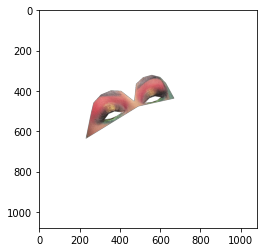

In [ ]:
plt.imshow(eyelids)

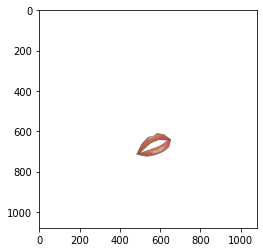

In [ ]:
plt.imshow(lips)

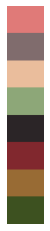

In [ ]:
plt.imshow(create_color_palette(eyes_colors))
plt.axis('off')
plt.show()

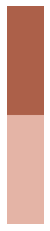

In [ ]:
plt.imshow(create_color_palette(lips_colors))
plt.axis('off')
plt.show()

----

In [ ]:
from os import listdir
from os.path import isfile, join

dir_path = r'/content/drive/MyDrive/csc_makeup/unzip_images/images/#v93oo'
n_files = 300
files = [join(dir_path, f) for f in listdir(dir_path)[:n_files] if isfile(join(dir_path, f))]

----

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
! pip install colormath

In [ ]:
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

In [ ]:
from collections import defaultdict

In [ ]:
class BuildDataset():
    def __init__(self, files, n_colors=3):
        self.files = files
        self.n_colors = n_colors
        self.columns = ['col' + str(n) + '_' + coord for n in range(1, n_colors+1) for coord in 'lab']
        self.df = pd.DataFrame(columns=self.columns)
        self.makeup_extractor = ExtractMakeup()
        self.colors_extractor = ExtractColors()
    
    def extract_color_features(self, img):
        makeup = self.makeup_extractor.extract(img)
        if makeup is None:
            return
        colors = self.colors_extractor.extract(makeup)
        
        color_features = defaultdict(list)
        for idx, (color, pixels) in enumerate(colors[:self.n_colors]):
            color_rgb = sRGBColor(*color)
            color_lab = convert_color(color_rgb, LabColor)
            i = 3*idx
            color_features[self.columns[i]].append(color_lab.lab_l)
            color_features[self.columns[i+1]].append(color_lab.lab_a)
            color_features[self.columns[i+2]].append(color_lab.lab_b)
        return color_features

    def build(self):
        try:
            for file in self.files:
                img = plt.imread(file)
                features = self.extract_color_features(img)
                if features is not None:
                    new_row = pd.DataFrame(features)
                    self.df = self.df.append(new_row, ignore_index=True)
        except:
            print(file)
        return self.df

In [ ]:
dataset_builder = BuildDataset(files)

In [ ]:
dataset_builder.df.head()

,col1_l,col1_a,col1_b,col2_l,col2_a,col2_b,col3_l,col3_a,col3_b


In [ ]:
df = dataset_builder.build()

/content/drive/MyDrive/csc_makeup/unzip_images/images/#v93oo/49d46f70-9bc5-4c8f-9cc8-415358cb0ea1.jpg


---

In [ ]:
! pip install face-alignment

  Created wheel for face-alignment: filename=face_alignment-1.3.3-py2.py3-none-any.whl size=27562 sha256=f8c68a833ef7ad21fe7f854102e7b712e5a9cf03c9e6ec1331b84a2053556d9f
  Stored in directory: /root/.cache/pip/wheels/76/1b/f7/7c61075544ea85a866ec89d1b455b123dad18c13361c02ff2b
Successfully built face-alignment


In [ ]:
class ExtractMakeup:
    def __init__(self):
        # define landmarks numbers for different regions
        self.left_eyelid = [0] + list(range(17, 22)) + [27, 28]
        self.right_eyelid = [28, 27] + list(range(22, 27)) + [16]
        self.eyelids = [self.left_eyelid, self.right_eyelid]

        self.left_eye = list(range(36, 42))
        self.right_eye = list(range(42, 48))
        self.eyes = [self.left_eye, self.right_eye]

        self.mouth = list(range(48, 60))
        self.teeth = list(range(60, 68))

        self.landmarks_predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)

        
    def get_landmarks(self, regions):
        points = []
        for region in regions:
            cur_points = []

            for n in region:
                cur_points.append(np.array(self.landmarks[n]))
            
            points.append(np.array(cur_points))
        
        return points

    def extract(self, img):
        self.img = img
        self.mask = np.zeros(self.img.shape[:2], dtype=np.uint8)

        self.landmarks = np.int32(self.landmarks_predictor.get_landmarks(self.img)[0])

        # eyelids + eyes region mask
        eyelids_landmarks = self.get_landmarks(self.eyelids)
        eyelids_mask = self.get_mask(eyelids_landmarks)

        # eyes region mask
        eyes_landmarks = self.get_landmarks(self.eyes)
        eyes_mask = self.get_mask(eyes_landmarks)

        # only eyelids mask
        eyelids_mask = cv2.bitwise_and(eyelids_mask, (255 - eyes_mask))

        # mouth region mask (lips + teeth)
        mouth_landmarks = self.get_landmarks([self.mouth])
        mouth_mask = self.get_mask(mouth_landmarks)
        
        # teeth region mask 
        teeth_landmarks = self.get_landmarks([self.teeth])
        teeth_mask = self.get_mask(teeth_landmarks)

        # lips (exclude teeth region)
        lips_mask = cv2.bitwise_and(mouth_mask, (255-teeth_mask))

        # full mask
        self.mask = cv2.bitwise_or(eyelids_mask, lips_mask)
        self.mask = np.array([self.mask]*3)
        self.mask = np.transpose(self.mask, [1, 2, 0])

        # get regions from input image
        self.img_mask = cv2.bitwise_and(self.img, self.mask)

        self.top = max(np.min([y for eye in eyelids_landmarks for x, y in eye]), 0)
        self.bottom = min(np.max([y for m in mouth_landmarks for x, y in m]), self.img.shape[0])
        self.left = max(np.min([x for eye in eyelids_landmarks for x, y in eye]), 0)
        self.right = min(np.max([x for eye in eyelids_landmarks for x, y in eye]), self.img.shape[1])

        self.img_crop = self.img_mask[self.top:self.bottom, self.left:self.right]
        self.mask_crop = self.mask[self.top:self.bottom, self.left:self.right]

        self.transparent_img = self.add_transparent_background(self.img_crop, self.mask_crop)
        return self.transparent_img

    def get_mask(self, points):
        mask = np.zeros(self.img.shape[:2], dtype=np.uint8)
        mask = cv2.fillPoly(mask, points, 255)
        return mask

    def add_transparent_background(self, img, mask):
        res = img.copy()
        res = cv2.cvtColor(res, cv2.COLOR_BGR2BGRA)
        res[:, :, 3] = mask[:, :, 0]
        return res

    def plot_face_box(self):
        x = self.face.left()
        y = self.face.top()
        w = self.face.right() - x
        h = self.face.bottom() - y
        img = self.img.copy()
        plt.imshow(cv2.rectangle(img, (x,y), (x+w,y+h), (0,0,255), 2))

In [ ]:
extr = ExtractMakeup()

In [ ]:
extr_colors = ExtractColors()

In [ ]:
f = r'/content/drive/MyDrive/csc_makeup/unzip_images/images/#v93oo/49d46f70-9bc5-4c8f-9cc8-415358cb0ea1.jpg'


In [ ]:
img = plt.imread(f, 'jpg')

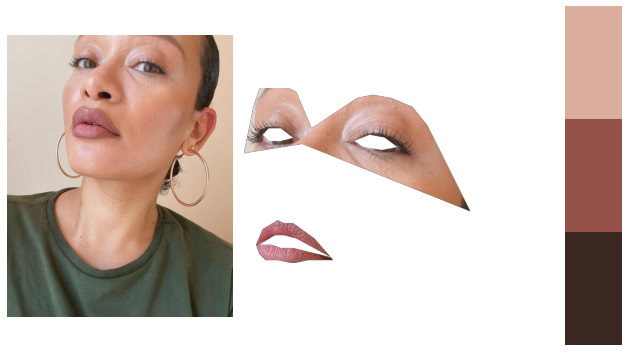

In [ ]:
plot_results(img, extr, extr_colors)